<a href="https://colab.research.google.com/github/Soulfex/-Tumor-Growth-With-Cellular-Automata/blob/main/Paper_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Aprendizaje Profundo</center></h1>
<h3><center> FinRL: A Deep Reinforcement Learning Library for
Automated Stock Trading in Quantitative Finance </center></h3>

<h4><center>Posgrado en Ciencia e Ingeniería de la Computación - UNAM</center></h4>




<h9><center>Equipo: </center></h9>
<h9><center>Ricardo Daniel Fernandez Noguez
 </center></h9>
 <h9><center> Félix Sánchez Morales
 </center></h9>

 

# 1. Importamos librerías

En esta libreta se entrenó un modelo utilizando Deep Reinforcement Learning para traiding en finanzas mediante el uso de la librería [FinRL](https://finrl.readthedocs.io/en/latest/index.html).

---



In [1]:
# Instalamos FinRL
!pip install git+https://github.com/Phantom-eva/FinRL.git
#! pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Phantom-eva/FinRL.git to /tmp/pip-req-build-8yqbhemy
  Running command git clone -q https://github.com/Phantom-eva/FinRL.git /tmp/pip-req-build-8yqbhemy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-hi6kvha2/elegantrl_9295b8b85dfd49d3bb63a57dad40c05a
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-hi6kvha2/elegantrl_9295b8b85dfd49d3bb63a57dad40c05a
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-hi6kvha2/pyfolio_273b704851044c4b9579d494c9008659
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-hi6kvha2/pyfolio_273b704851044c4b9579d494c9008659


In [7]:
# Importamos 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime


%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Portafolios

In [58]:
cs_s = ['MCD'  # Consumer Services
        ,'DIS','SBUX','BKNG','ABNB','MAR','WBD','V','MA']

e_m = ['XOM' # Energy Minerals
       ,'SHEL','PRCH','EQNR','BP','PBR','SNP','CNQ','OXY','PXD']

e_t = ['AAPL' # Electronic Technologies
       ,'TSM','NVDA','INTC','QCOM','TXN','RTX','AMD'] 
r_t =['AMZN' # Retail Trade
      ,'WMT','BABA','HD','COST','TJX','ORLY','AZO']



# 1.2 Creamos folders

In [9]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [10]:

config.TRAIN_START_DATE

'2014-01-06'

In [11]:

config.TRAIN_END_DATE

'2020-07-31'

# 2. Descargamos los datos

Yahoo Finance proporciona datos bursátiles, noticias financieras, informes financieros, etc. Yahoo Finance es gratuito.

## Portfolio 1: Consumer Services
MCD, DIS, SBUX, BKNG, ABNB, MAR, WBD, V, MA.

In [12]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = cs_s).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26064, 8)


In [13]:
df.shape

(26064, 8)

In [15]:
df.sort_values(['date','tic'],ignore_index=True)

,date,open,high,low,close,volume,tic,day
0,2009-01-02,74.269997,77.110001,73.139999,76.889999,1085100,BKNG,4
1,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600,DIS,4
2,2009-01-02,14.410000,15.070000,14.273000,13.968310,22311000,MA,4
3,2009-01-02,18.196844,18.989227,18.178200,16.227430,6078424,MAR,4
4,2009-01-02,62.380001,64.129997,62.200001,42.632050,8652700,MCD,4
...,...,...,...,...,...,...,...,...
26059,2021-10-29,159.000000,161.050003,157.449997,159.040588,2025400,MAR,4
26060,2021-10-29,243.000000,246.089996,242.470001,238.846863,4329400,MCD,4
26061,2021-10-29,107.500000,107.989998,104.019997,103.162811,27419600,SBUX,4
26062,2021-10-29,209.210007,213.669998,208.539993,209.810760,14329800,V,4


# 2.1 Prepocesamiento de datos

Se nececita verificar si faltan datos, de ser así de debe aplicar alguna de las estrategias vistas en Aprendizaje automatizado.

$\textbf{Adición de indicadores técnicos} $. En el comercio práctico, se debe tener en cuenta información diversa, como precios históricos, acciones de tenencia actuales, indicadores técnicos, etc. Aquí, mostramos dos indicadores técnicos que siguen la tendencia: MACD y RSI.

$\textbf{Añadir índice de turbulencia}$. La aversión al riesgo refleja si un inversor prefiere proteger el capital. También influye en la estrategia comercial de uno cuando se enfrenta a diferentes niveles de volatilidad del mercado. 


In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True, # El índice de volatilidad 
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [17]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [18]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,BKNG,74.269997,77.110001,73.139999,76.889999,1085100.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,76.889999,76.889999,39.189999,0.0
1,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597496,9796600.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,20.597496,20.597496,39.189999,0.0
2,2009-01-02,MA,14.410000,15.070000,14.273000,13.968310,22311000.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,13.968310,13.968310,39.189999,0.0
3,2009-01-02,MAR,18.196844,18.989227,18.178200,16.227430,6078424.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,16.227430,16.227430,39.189999,0.0
4,2009-01-02,MCD,62.380001,64.129997,62.200001,42.632050,8652700.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,42.632050,42.632050,39.189999,0.0
5,2009-01-02,SBUX,4.705000,4.930000,4.665000,3.951461,14885400.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,3.951461,3.951461,39.189999,0.0
6,2009-01-02,V,13.230000,13.427500,13.060000,12.102947,13199200.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,12.102947,12.102947,39.189999,0.0
7,2009-01-02,WBD,7.220235,7.552376,7.189576,7.485948,2796553.0,4.0,0.000000,78.617862,73.272137,0.0,-66.666667,100.0,7.485948,7.485948,39.189999,0.0
8,2009-01-05,BKNG,76.070000,76.550003,73.610001,75.000000,1139700.0,0.0,-0.042404,78.617862,73.272137,0.0,-66.666667,100.0,75.945000,75.945000,39.080002,0.0
9,2009-01-05,DIS,23.510000,24.000000,23.290001,20.235834,11675100.0,0.0,-0.008114,20.928132,19.905198,0.0,66.666667,100.0,20.416665,20.416665,39.080002,0.0


In [19]:
processed_full.shape

(25832, 18)

 # 3. Diseño del entorno

Dividimos los datos en conjunto de entrenamiento y conjunto de prueba de la siguiente manera:

Período de datos de entrenamiento: 2009-01-01 a 2020-07-01

Período de datos comerciales: 2020-07-01 a 2021-10-31

In [20]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

23144
2688


In [21]:
print(f"train.tic.unique(): {train.tic.unique()}")

train.tic.unique(): ['BKNG' 'DIS' 'MA' 'MAR' 'MCD' 'SBUX' 'V' 'WBD']


In [22]:
print(f"train.head(): {train.head()}")

train.head():          date   tic       open       high        low      close      volume  \
0  2009-01-02  BKNG  74.269997  77.110001  73.139999  76.889999   1085100.0   
0  2009-01-02   DIS  22.760000  24.030001  22.500000  20.597496   9796600.0   
0  2009-01-02    MA  14.410000  15.070000  14.273000  13.968310  22311000.0   
0  2009-01-02   MAR  18.196844  18.989227  18.178200  16.227430   6078424.0   
0  2009-01-02   MCD  62.380001  64.129997  62.200001  42.632050   8652700.0   

   day  macd    boll_ub    boll_lb  rsi_30     cci_30  dx_30  close_30_sma  \
0  4.0   0.0  78.617862  73.272137     0.0 -66.666667  100.0     76.889999   
0  4.0   0.0  78.617862  73.272137     0.0 -66.666667  100.0     20.597496   
0  4.0   0.0  78.617862  73.272137     0.0 -66.666667  100.0     13.968310   
0  4.0   0.0  78.617862  73.272137     0.0 -66.666667  100.0     16.227430   
0  4.0   0.0  78.617862  73.272137     0.0 -66.666667  100.0     42.632050   

   close_60_sma        vix  turbulence  
0

In [23]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


In [25]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Entorno para el entrenamiento

El proceso de entrenamiento consiste en observar el cambio de precio de las acciones, realizar una acción y calcular la recompensa. Al interactuar con el entorno del mercado, el agente finalmente derivará una estrategia comercial que puede maximizar las recompensas (esperadas).

Nuestro entorno de mercado, basado en OpenAI Gym, simula mercados bursátiles con datos históricos del mercado.

In [26]:
env_train, _ = e_train_gym.get_sb_env()
print(env_train.__doc__)


    Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
    Python process. This is useful for computationally simple environment such as ``cartpole-v1``,
    as the overhead of multiprocess or multithread outweighs the environment computation time.
    This can also be used for RL methods that
    require a vectorized environment, but that you want a single environments to train with.

    :param env_fns: a list of functions
        that return environments to vectorize
    


# Entrenamos al agente de DRL con Deep Deterministic Policy Gradient (DDPG)

In [41]:
agent = DRLAgent(env = env_train)
parameters  = {
    "learning_rate": 0.0005318179334,
    "batch_size" : 875
        }

model_ddpg = agent.get_model("ddpg", model_kwargs = parameters)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) 

{'learning_rate': 0.0005318179334, 'batch_size': 875}
Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 99        |
|    time_elapsed    | 116       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 792       |
|    critic_loss     | 1.55e+03  |
|    learning_rate   | 0.000532  |
|    n_updates       | 8679      |
|    reward          | 4.8366237 |
----------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 6649934.91
total_reward: 5649934.91
total_cost: 998.99
total_trades: 11568
Sharpe: 1.000
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 89        |
|    time_elapsed    | 259       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 243       |
|    critic_loss     | 300       |

# Train DRL Agents con Proximal Policy Optimization (PPO)

In [ ]:
print(type(state_space), type (stock_dimension))

<class 'int'> <class 'int'>


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 70        |
|    iterations      | 1         |
|    time_elapsed    | 28        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5672113 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 2           |
|    time_elapsed         | 55          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015866006 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00465    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.36        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0276     |
|    reward  

In [42]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [43]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [44]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean        8.466465
std        14.592292
min         0.000000
25%         2.492087
50%         4.743854
75%         8.842290
max       188.881373
Name: turbulence, dtype: float64

In [45]:
insample_risk_indicator.turbulence.quantile(0.996)

116.02203255374997

In [46]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [47]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model= model_ddpg, 
    environment = e_trade_gym)

hit end!


In [48]:
df_account_value.shape

(336, 2)

In [49]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.282965e+06
332,2021-10-25,1.287243e+06
333,2021-10-26,1.279876e+06
334,2021-10-27,1.252601e+06
335,2021-10-28,1.246235e+06


In [50]:
df_actions.head()

,BKNG,DIS,MA,MAR,MCD,SBUX,V,WBD
date,,,,,,,,
2020-07-01,0,0,0,0,100,100,100,100
2020-07-02,0,0,0,0,100,100,100,100
2020-07-06,0,0,0,0,100,100,100,100
2020-07-07,0,0,0,0,100,100,100,100
2020-07-08,0,0,0,0,100,100,100,100


In [51]:
data_risk_indicator = processed_full[(processed_full.date<config.TRAIN_END_DATE) & (processed_full.date>=config.TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [52]:
insample_risk_indicator.vix.describe()

count    1654.000000
mean       16.473337
std         7.673456
min         9.140000
25%        12.420000
50%        14.210000
75%        17.565000
max        82.690002
Name: vix, dtype: float64

# Backtesting

In [53]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.179505
Cumulative returns     0.246235
Annual volatility      0.154415
Sharpe ratio           1.149844
Calmar ratio           1.994415
Stability              0.838605
Max drawdown          -0.090004
Omega ratio            1.207033
Sortino ratio          1.645480
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.974848
Daily value at risk   -0.018750
dtype: float64


In [54]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,17.951%
Cumulative returns,24.623%
Annual volatility,15.442%
Sharpe ratio,1.15
Calmar ratio,1.99
Stability,0.84
Max drawdown,-9.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.00,2021-07-27,2021-10-28,NaT,NaN
1,8.14,2020-10-12,2020-10-28,2020-11-11,23
2,7.16,2021-03-16,2021-03-31,2021-07-15,88
3,5.65,2021-01-08,2021-01-29,2021-02-09,23
4,5.38,2020-09-02,2020-09-23,2020-10-09,28


Stress Events,mean,min,max
New Normal,0.07%,-4.07%,3.42%


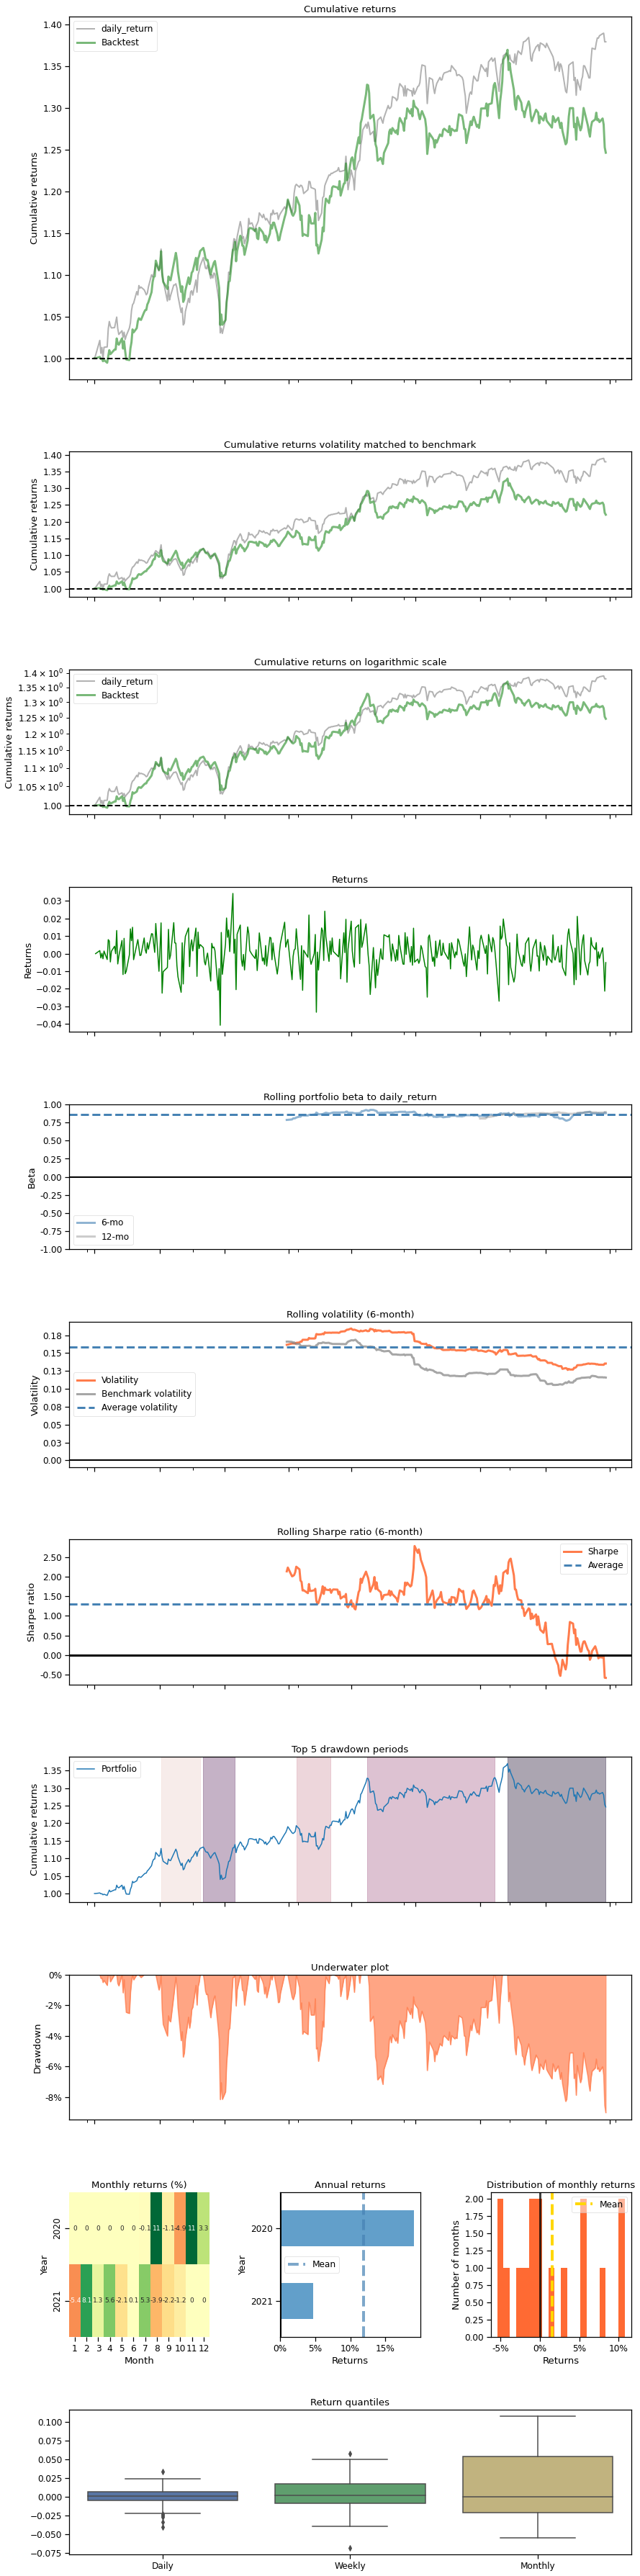

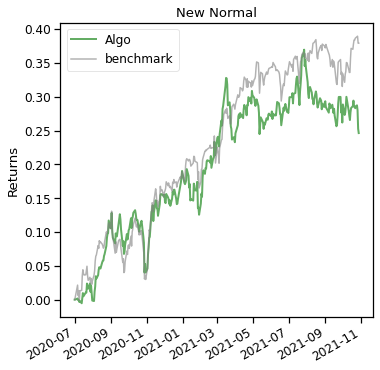

In [55]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

## Portfolio 2: Energy Minerals
XOM, SHEL, PTR, EQNR, BP,PBR ,SNP ,CNQ, OXY, PXD

In [59]:
df2 = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = e_m).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SNP: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26295, 8)


In [60]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True, # El índice de volatilidad 
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df2)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [61]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [62]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,BP,47.000000,48.619999,46.959999,22.706566,5969700.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,22.706566,22.706566,39.189999,0.0
1,2009-01-02,CNQ,19.867777,21.180216,19.696377,13.970254,4749284.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,13.970254,13.970254,39.189999,0.0
2,2009-01-02,EQNR,16.879999,17.360001,16.850000,9.141766,1484700.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,9.141766,9.141766,39.189999,0.0
3,2009-01-02,OXY,58.068104,60.022549,57.004654,39.119114,7093282.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,39.119114,39.119114,39.189999,0.0
4,2009-01-02,PBR,24.230000,26.260000,24.209999,10.749704,16981700.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,10.749704,10.749704,39.189999,0.0
5,2009-01-02,PXD,16.370001,18.120001,16.200001,14.964093,3426800.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,14.964093,14.964093,39.189999,0.0
6,2009-01-02,SHEL,53.790001,55.430000,53.709999,25.770689,1706715.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,25.770689,25.770689,39.189999,0.0
7,2009-01-02,XOM,80.059998,82.110001,78.900002,48.463039,35803700.0,4.0,0.000000,23.226891,22.458063,100.0,66.666667,100.0,48.463039,48.463039,39.189999,0.0
8,2009-01-05,BP,48.250000,49.830002,48.250000,22.978388,7040800.0,0.0,0.006099,23.226891,22.458063,100.0,66.666667,100.0,22.842477,22.842477,39.080002,0.0
9,2009-01-05,CNQ,21.317335,22.967678,21.145935,15.078842,8436523.0,0.0,0.024872,16.092329,12.956768,100.0,66.666667,100.0,14.524548,14.524548,39.080002,0.0


In [63]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

23144
2688


In [68]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


In [69]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [70]:
env_train, _ = e_train_gym.get_sb_env()
print(env_train.__doc__)


    Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
    Python process. This is useful for computationally simple environment such as ``cartpole-v1``,
    as the overhead of multiprocess or multithread outweighs the environment computation time.
    This can also be used for RL methods that
    require a vectorized environment, but that you want a single environments to train with.

    :param env_fns: a list of functions
        that return environments to vectorize
    


In [71]:
agent = DRLAgent(env = env_train)
parameters  = {
    "learning_rate": 0.001189938411,
    "batch_size" : 800
        }

model_ddpg = agent.get_model("ddpg", model_kwargs = parameters)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) 

{'learning_rate': 0.001189938411, 'batch_size': 800}
Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 104       |
|    time_elapsed    | 111       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 163       |
|    critic_loss     | 819       |
|    learning_rate   | 0.00119   |
|    n_updates       | 8679      |
|    reward          | 3.5766463 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 93        |
|    time_elapsed    | 246       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | -2.96     |
|    critic_loss     | 140       |
|    learning_rate   | 0.00119   |
|    n_updates       | 20251     |
|    reward          | 3.5766463 |
----------------------------------
day: 2892, episode:

In [72]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model= model_ddpg, 
    environment = e_trade_gym)

hit end!


In [73]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.248261
Cumulative returns     0.344025
Annual volatility      0.196425
Sharpe ratio           1.230533
Calmar ratio           2.172594
Stability              0.783895
Max drawdown          -0.114270
Omega ratio            1.240106
Sortino ratio          1.857294
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.111644
Daily value at risk   -0.023788
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,24.826%
Cumulative returns,34.402%
Annual volatility,19.643%
Sharpe ratio,1.23
Calmar ratio,2.17
Stability,0.78
Max drawdown,-11.427%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.43,2020-08-28,2020-11-02,2020-11-09,52
1,9.07,2020-12-31,2021-01-27,2021-02-23,39
2,7.38,2021-07-27,2021-09-21,NaT,NaN
3,6.15,2021-04-29,2021-05-12,2021-07-23,62
4,4.46,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.10%,-5.32%,7.26%


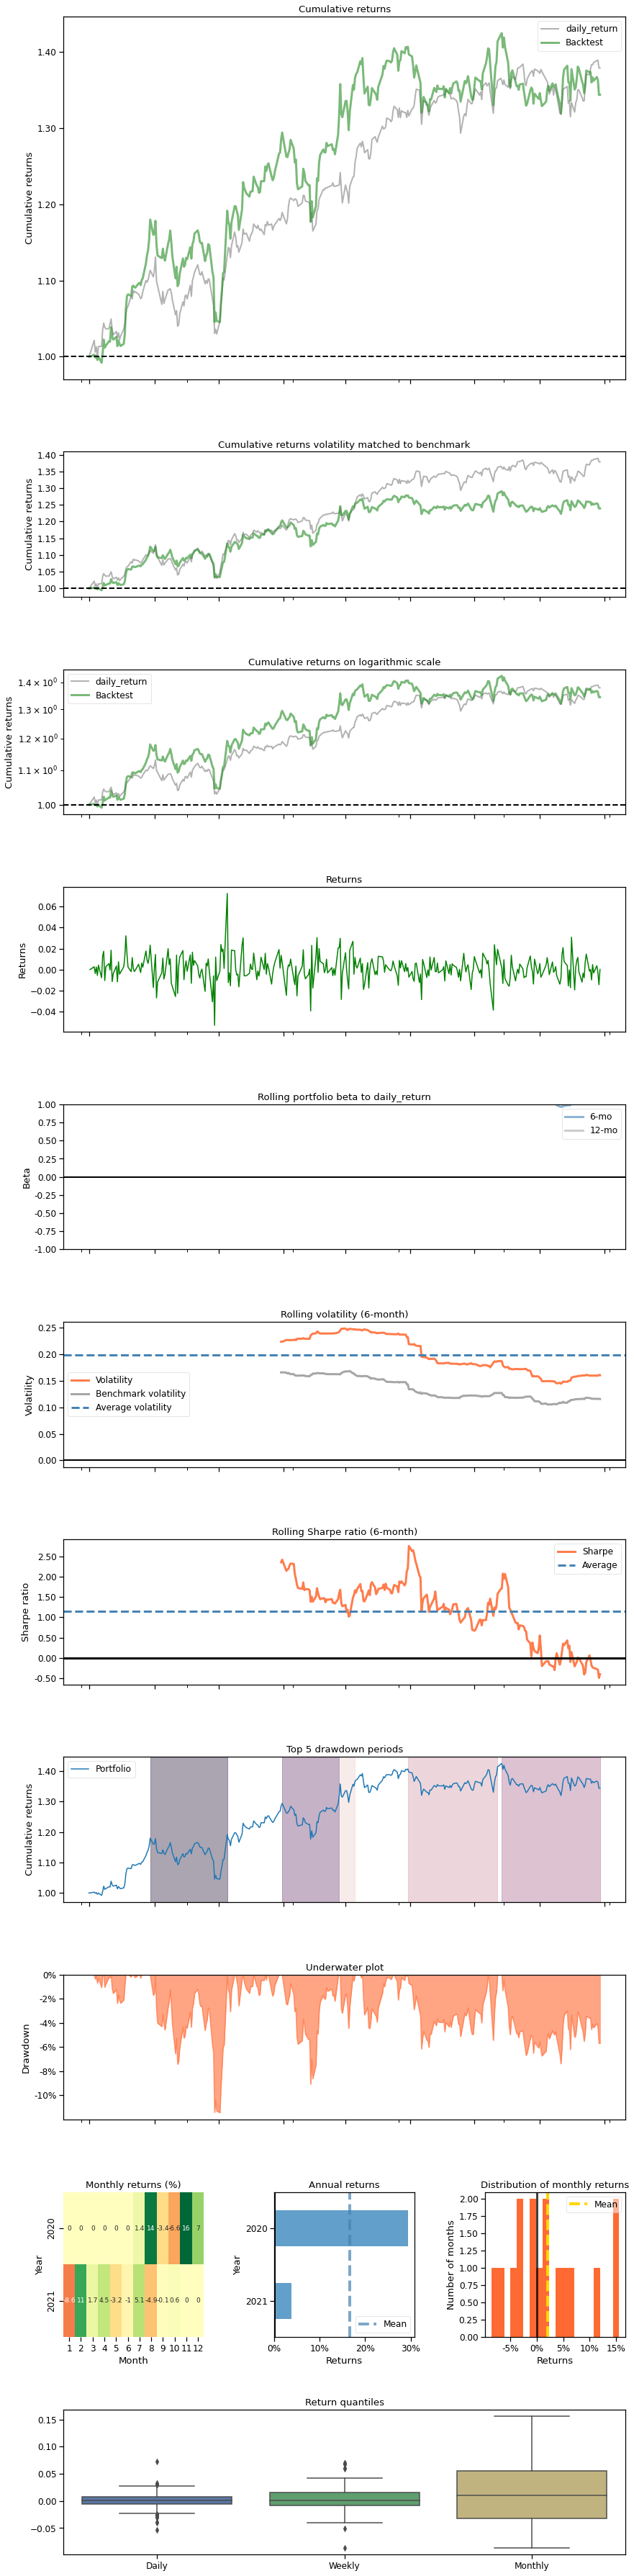

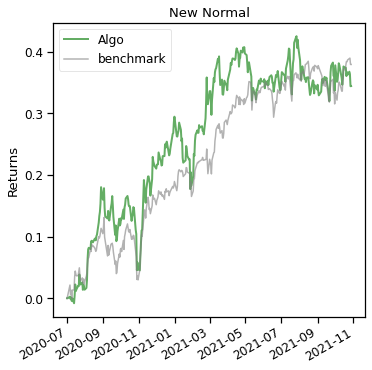

In [74]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

## Portfolio 3: Electronic Technologies
AAPL, TSM, NVDA, INTC, QCOM, TXN, RTX, AMD.

In [75]:
df3 = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = e_t).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (25840, 8)


In [76]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True, # El índice de volatilidad 
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df3)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [77]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [78]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.762747,7.460152e+08,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,2.762747,2.762747,39.189999,0.0
1,2009-01-02,AMD,2.190000,2.430000,2.170000,2.380000,1.383210e+07,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,2.380000,2.380000,39.189999,0.0
2,2009-01-02,INTC,14.690000,15.250000,14.470000,9.869510,5.220820e+07,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,9.869510,9.869510,39.189999,0.0
3,2009-01-02,NVDA,2.017500,2.192500,2.010000,1.998406,4.971240e+07,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,1.998406,1.998406,39.189999,0.0
4,2009-01-02,QCOM,35.650002,37.130001,35.349998,26.081276,1.475660e+07,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,26.081276,26.081276,39.189999,0.0
5,2009-01-02,RTX,33.643803,34.764004,33.373192,24.663568,7.452887e+06,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,24.663568,24.663568,39.189999,0.0
6,2009-01-02,TSM,7.731343,8.248756,7.731343,5.150162,9.887190e+06,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,5.150162,5.150162,39.189999,0.0
7,2009-01-02,TXN,15.500000,16.170000,15.400000,11.308821,1.519450e+07,4.0,0.000000,2.985943,2.656150,100.0,66.666667,100.0,11.308821,11.308821,39.189999,0.0
8,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.879346,1.181608e+09,0.0,0.002616,2.985943,2.656150,100.0,66.666667,100.0,2.821046,2.821046,39.080002,0.0
9,2009-01-05,AMD,2.370000,2.680000,2.350000,2.670000,1.932690e+07,0.0,0.006506,2.935122,2.114878,100.0,66.666667,100.0,2.525000,2.525000,39.080002,0.0


In [79]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

23144
2688


In [80]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


In [81]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [82]:
env_train, _ = e_train_gym.get_sb_env()
print(env_train.__doc__)


    Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
    Python process. This is useful for computationally simple environment such as ``cartpole-v1``,
    as the overhead of multiprocess or multithread outweighs the environment computation time.
    This can also be used for RL methods that
    require a vectorized environment, but that you want a single environments to train with.

    :param env_fns: a list of functions
        that return environments to vectorize
    


In [83]:
agent = DRLAgent(env = env_train)
parameters  = {
    "learning_rate": 0.04 ,
    "batch_size" : 795
        }

model_ddpg = agent.get_model("ddpg", model_kwargs = parameters)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) 

{'learning_rate': 0.04, 'batch_size': 795}
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 104      |
|    time_elapsed    | 110      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 40.8     |
|    critic_loss     | 103      |
|    learning_rate   | 0.04     |
|    n_updates       | 8679     |
|    reward          | 7.671641 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 94       |
|    time_elapsed    | 244      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 7.5      |
|    critic_loss     | 47.2     |
|    learning_rate   | 0.04     |
|    n_updates       | 20251    |
|    reward          | 7.671641 |
---------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
en

In [84]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model= model_ddpg, 
    environment = e_trade_gym)

hit end!


In [85]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.265670
Cumulative returns     0.369075
Annual volatility      0.280843
Sharpe ratio           0.979543
Calmar ratio           1.672419
Stability              0.729391
Max drawdown          -0.158853
Omega ratio            1.190095
Sortino ratio          1.587907
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.095979
Daily value at risk   -0.034291
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,26.567%
Cumulative returns,36.907%
Annual volatility,28.084%
Sharpe ratio,0.98
Calmar ratio,1.67
Stability,0.73
Max drawdown,-15.885%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.89,2020-09-02,2020-10-28,2020-11-09,49
1,14.21,2021-01-08,2021-01-27,2021-02-22,32
2,13.19,2021-04-28,2021-08-20,NaT,NaN
3,8.96,2021-03-17,2021-03-24,2021-04-28,31
4,7.05,2021-02-24,2021-03-04,2021-03-12,13


Stress Events,mean,min,max
New Normal,0.11%,-5.59%,14.46%


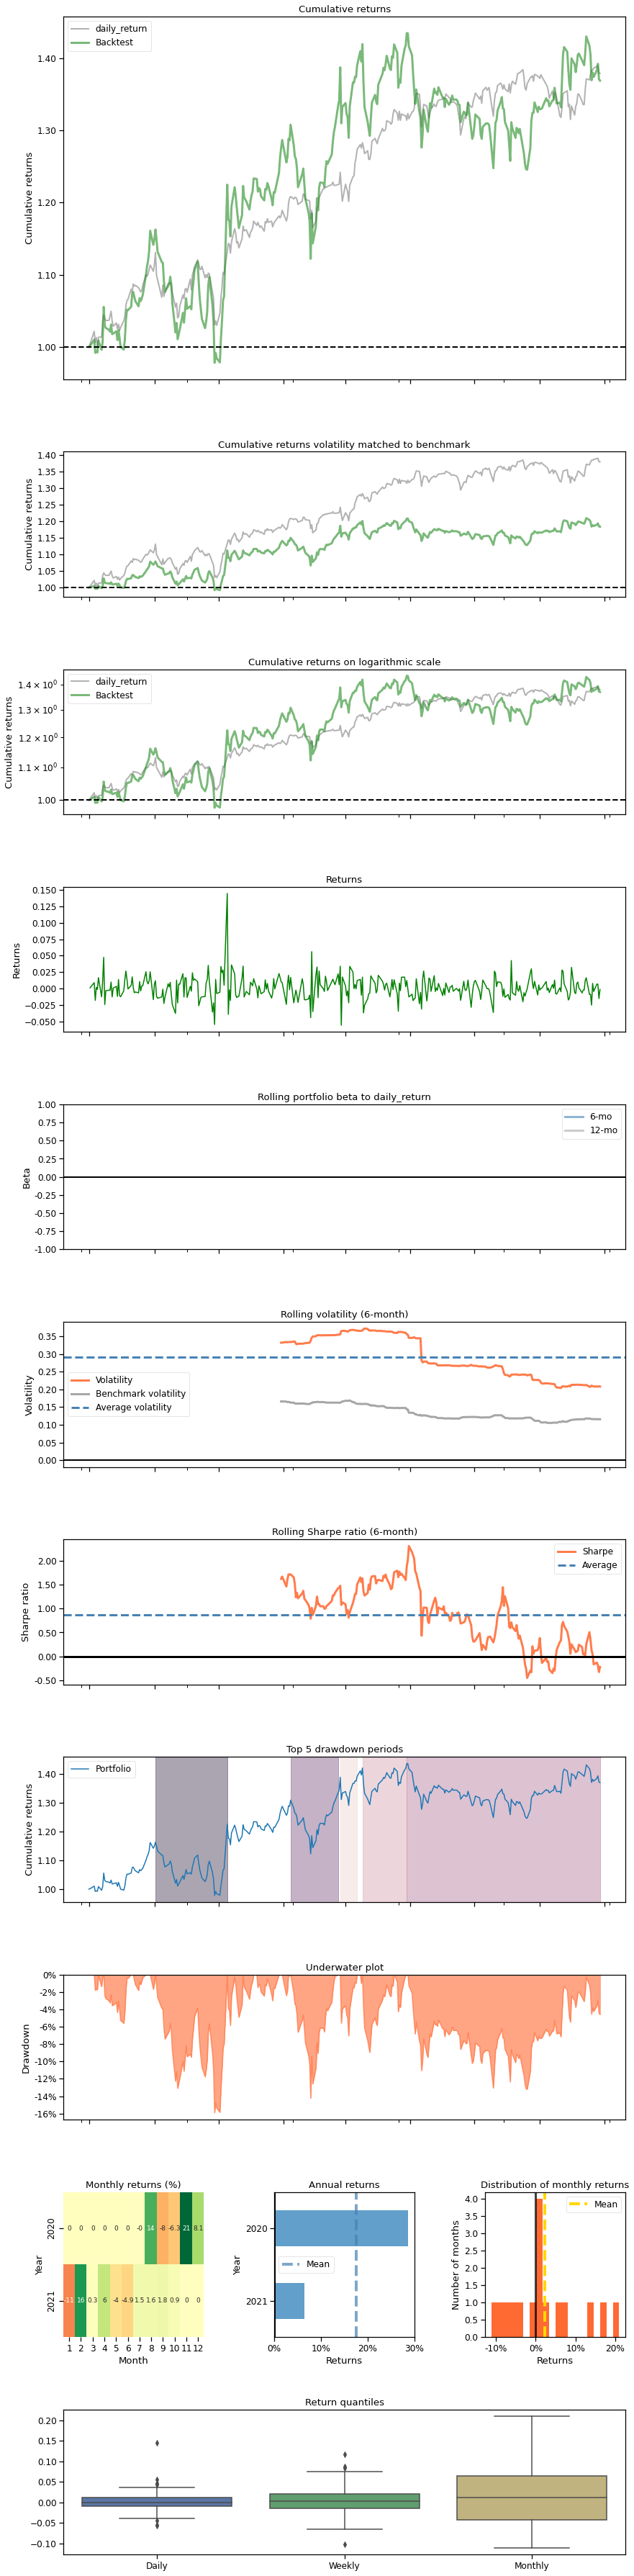

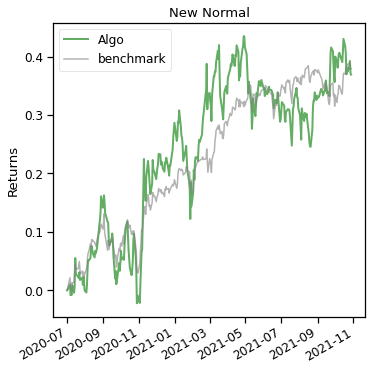

In [86]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

## Portfolio 4: Retail Trade
AMZN, WMT, BABA , HD, COST, TJX , ORLY, AZO.

In [87]:
df4 = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = r_t).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (24402, 8)


In [88]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True, # El índice de volatilidad 
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df4)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [89]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [90]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AMZN,2.567500,2.726500,2.553500,2.718000,145928000.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,2.718000,2.718000,39.189999,0.0
1,2009-01-02,AZO,138.940002,141.100006,138.080002,140.570007,1148800.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,140.570007,140.570007,39.189999,0.0
2,2009-01-02,COST,52.439999,53.500000,52.049999,38.890827,3687200.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,38.890827,38.890827,39.189999,0.0
3,2009-01-02,HD,23.070000,24.190001,22.959999,17.112440,14902500.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,17.112440,17.112440,39.189999,0.0
4,2009-01-02,ORLY,30.590000,31.580000,30.139999,31.430000,1361600.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,31.430000,31.430000,39.189999,0.0
5,2009-01-02,TJX,5.102500,5.412500,5.102500,4.475555,14485200.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,4.475555,4.475555,39.189999,0.0
6,2009-01-02,WMT,55.980000,57.509998,55.779999,41.775776,16054800.0,4.0,0.000000,2.731713,2.689287,0.0,66.666667,100.0,41.775776,41.775776,39.189999,0.0
7,2009-01-05,AMZN,2.786500,2.787000,2.651500,2.703000,190196000.0,0.0,-0.000337,2.731713,2.689287,0.0,66.666667,100.0,2.710500,2.710500,39.080002,0.0
8,2009-01-05,AZO,140.800003,141.779999,136.550003,137.729996,1493500.0,0.0,-0.063718,143.166384,135.133619,0.0,-66.666667,100.0,139.150002,139.150002,39.080002,0.0
9,2009-01-05,COST,53.180000,53.619999,51.799999,38.118130,5890900.0,0.0,-0.017336,39.597238,37.411719,0.0,-66.666667,100.0,38.504478,38.504478,39.080002,0.0


In [91]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

20251
2352


In [92]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 7, State Space: 71


In [93]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [94]:
env_train, _ = e_train_gym.get_sb_env()
print(env_train.__doc__)


    Creates a simple vectorized wrapper for multiple environments, calling each environment in sequence on the current
    Python process. This is useful for computationally simple environment such as ``cartpole-v1``,
    as the overhead of multiprocess or multithread outweighs the environment computation time.
    This can also be used for RL methods that
    require a vectorized environment, but that you want a single environments to train with.

    :param env_fns: a list of functions
        that return environments to vectorize
    


In [95]:
agent = DRLAgent(env = env_train)
parameters  = {
    "learning_rate": 0.04776821861 ,
    "batch_size" : 1055
        }

model_ddpg = agent.get_model("ddpg", model_kwargs = parameters)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) 

{'learning_rate': 0.04776821861, 'batch_size': 1055}
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 103      |
|    time_elapsed    | 111      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | -63.1    |
|    critic_loss     | 107      |
|    learning_rate   | 0.0478   |
|    n_updates       | 8679     |
|    reward          | 3.715018 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 93       |
|    time_elapsed    | 248      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | -11.8    |
|    critic_loss     | 29.9     |
|    learning_rate   | 0.0478   |
|    n_updates       | 20251    |
|    reward          | 3.715018 |
---------------------------------
day: 2892, episode: 10
begin_total_asset: 100

In [97]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [98]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [99]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [100]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model= model_ddpg, 
    environment = e_trade_gym)

hit end!


In [101]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.365574
Cumulative returns     0.515026
Annual volatility      0.159182
Sharpe ratio           2.043865
Calmar ratio           3.841370
Stability              0.870263
Max drawdown          -0.095167
Omega ratio            1.396829
Sortino ratio          3.081812
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.249787
Daily value at risk   -0.018764
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,36.557%
Cumulative returns,51.503%
Annual volatility,15.918%
Sharpe ratio,2.04
Calmar ratio,3.84
Stability,0.87
Max drawdown,-9.517%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.52,2021-01-12,2021-03-04,2021-03-19,49
1,8.75,2020-09-02,2020-09-23,2021-01-08,93
2,6.68,2021-05-10,2021-06-10,2021-07-01,39
3,4.51,2021-09-29,2021-10-04,2021-10-15,13
4,3.91,2021-08-20,2021-09-02,2021-09-22,24


Stress Events,mean,min,max
New Normal,0.13%,-3.76%,2.68%


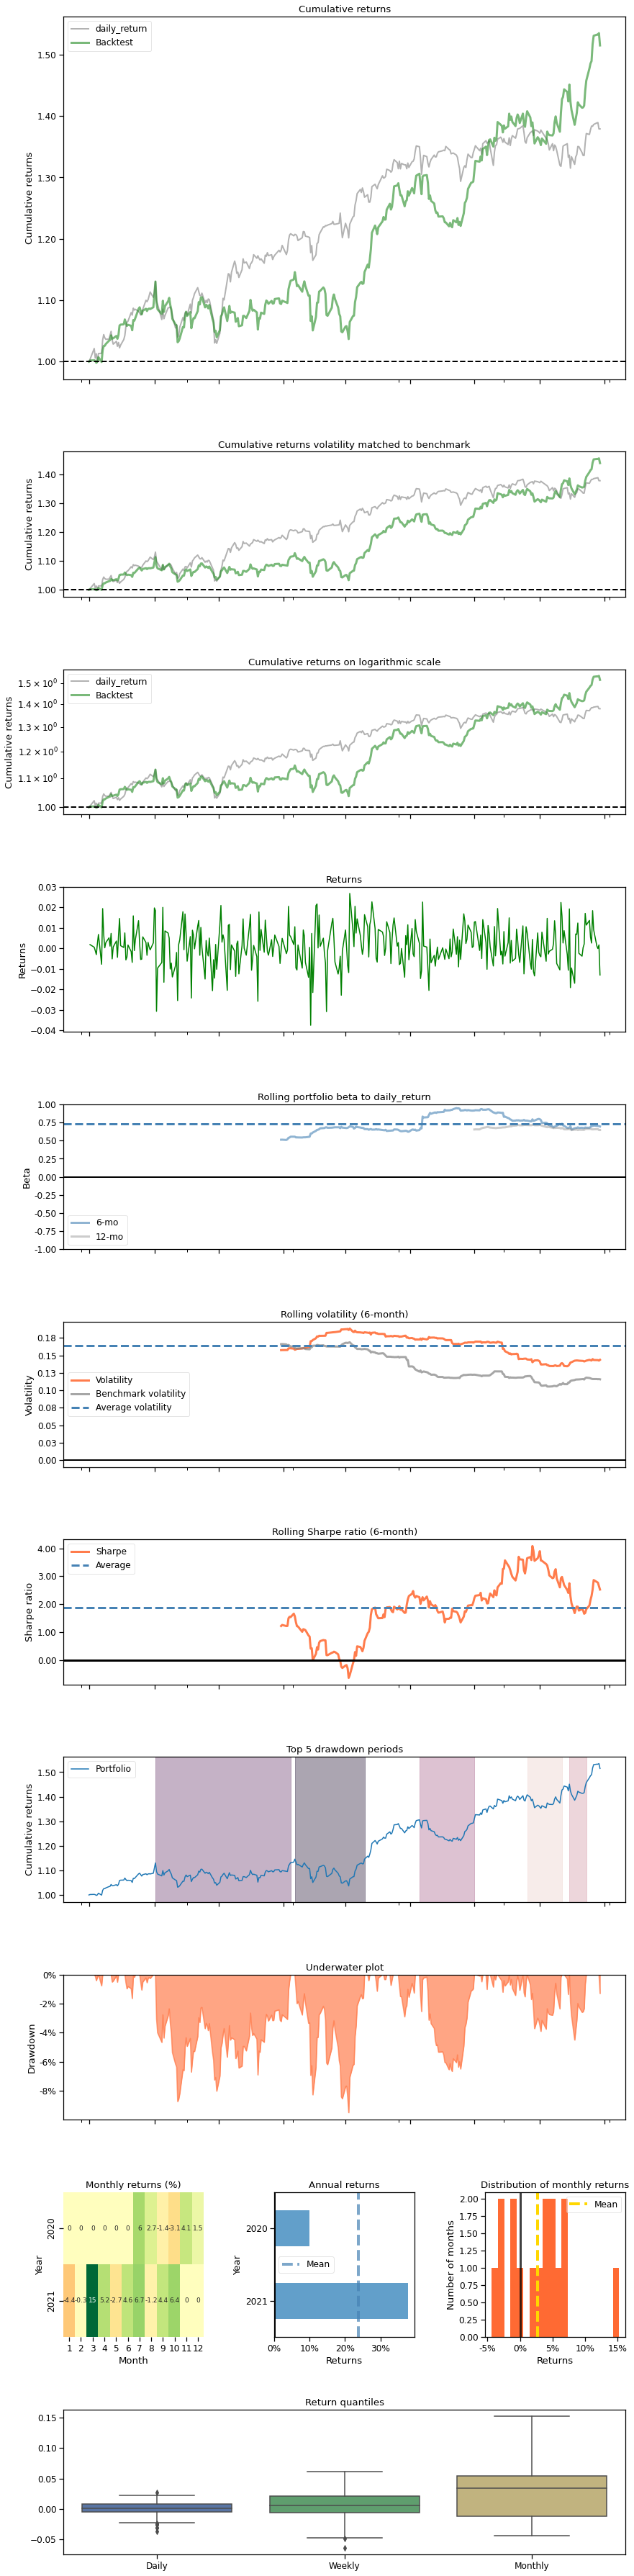

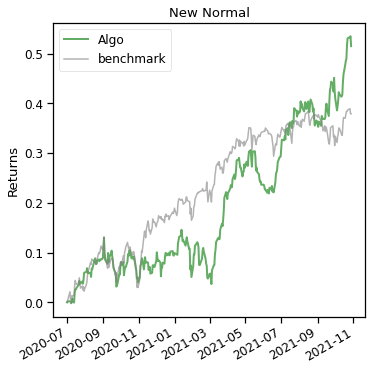

In [102]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])